# Importing the required libraries

In [1]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [2]:
with open("sarcasm.json","r") as f:
  json_file = json.load(f)

In [3]:
article_links = []
headlines = []
labels = []

In [4]:
for item in json_file:
    article_links.append(item['article_link'])
    headlines.append(item['headline'])
    labels.append(item['is_sarcastic'])

# Preprocessing the data

### Defining the hyperparameters

In [5]:
vocab_size = 1000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

### Splitting the dataset into training and validation data

In [6]:
shuffled_indices = np.random.permutation(len(headlines))
test_ratio = 0.2

train_indices = shuffled_indices[int(len(headlines)*test_ratio):]
test_indices = shuffled_indices[:int(len(headlines)*test_ratio)]

training_data = []
training_labels = []
validation_data = []
validation_labels = []

for indices in train_indices:
  training_data.append(headlines[indices])
  training_labels.append(labels[indices])
for indices in test_indices:
  validation_data.append(headlines[indices])
  validation_labels.append(labels[indices])

In [7]:
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

### Tokenizing and padding the input data

In [8]:
# Defining the tokenizer object
tokenizer = Tokenizer(num_words = vocab_size,oov_token = oov_tok)

# Fitting the data to get the encoded values for the words
tokenizer.fit_on_texts(training_data)
word_index = tokenizer.word_index

# Getting a sequence for each sentence
training_sequences = tokenizer.texts_to_sequences(training_data)
validation_sequences = tokenizer.texts_to_sequences(validation_data)

# Getting a proper matrix of values with different padding settings
training_padded = pad_sequences(training_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

validation_padded

array([[167, 319,  31, ...,   0,   0,   0],
       [ 42,   1,   1, ...,   0,   0,   0],
       [  1,   1, 398, ...,   0,   0,   0],
       ...,
       [199, 118, 557, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  4,   1, 801, ...,   0,   0,   0]], dtype=int32)

# Defining the model

In [9]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            16000     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 24)                12312     
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 28,337
Trainable params: 28,337
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [11]:
num_epochs = 10
history = model.fit(
    training_padded,
    training_labels,
    epochs = num_epochs,
    validation_data = (validation_padded,validation_labels)
)

Epoch 1/10
668/668 [==============================] - 5s 6ms/step - loss: 0.4521 - accuracy: 0.7749 - val_loss: 0.3673 - val_accuracy: 0.8229
Epoch 2/10
668/668 [==============================] - 4s 6ms/step - loss: 0.3232 - accuracy: 0.8548 - val_loss: 0.3626 - val_accuracy: 0.8236
Epoch 3/10
668/668 [==============================] - 4s 5ms/step - loss: 0.2875 - accuracy: 0.8755 - val_loss: 0.3704 - val_accuracy: 0.8285
Epoch 4/10
668/668 [==============================] - 4s 6ms/step - loss: 0.2582 - accuracy: 0.8896 - val_loss: 0.3827 - val_accuracy: 0.8276
Epoch 5/10
668/668 [==============================] - 4s 6ms/step - loss: 0.2314 - accuracy: 0.9036 - val_loss: 0.4083 - val_accuracy: 0.8143
Epoch 6/10
668/668 [==============================] - 3s 5ms/step - loss: 0.2048 - accuracy: 0.9164 - val_loss: 0.4519 - val_accuracy: 0.8109
Epoch 7/10
668/668 [==============================] - 3s 5ms/step - loss: 0.1825 - accuracy: 0.9292 - val_loss: 0.5035 - val_accuracy: 0.8075
Epoch 

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape

(1000, 16)

# Visualizing the trained result

In [13]:
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i,'?') for i in text])

print(decode_review(training_padded[3]))
print(training_data[5])

3 <OOV> ways to deal with <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
holy crap! british artist will cast your anus in bronze (nsfw)


In [14]:
import io

out_v = io.open('vesc.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf=8')

for word_num in range(1,vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
download = False
if(download):
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download('vesc.tsv')
    files.download('meta.tsv')

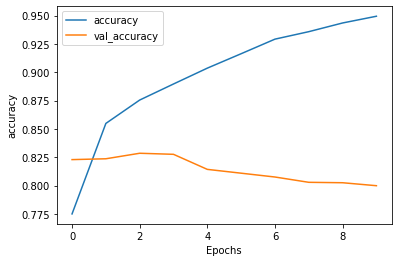

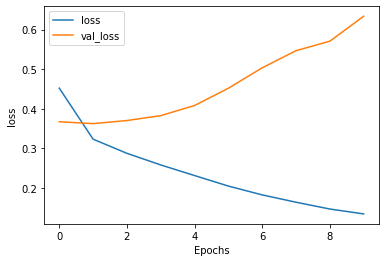

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Predicting the sarcasm level using the trained model

In [24]:
sentences = ["He really loves swimming", 
             "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)
print(model.predict(padded))

[[0.6739625]
 [0.9423766]]


In [19]:
training_labels

array([0, 0, 1, ..., 0, 1, 1])